In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-26 22:41:40.157801


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v2" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v2"]).reset_index(drop=True)

df_review:
source                     0
hotel_id                   0
hotel_name                 0
country                    0
group_name                 0
room_type                  0
stay_length                0
stay_date                  0
review_score               0
review_score_category      0
sentiment                  0
review_date                0
review_title               1
review                     0
review_cleaned_v1          0
review_cleaned_v2        229
dtype: int64
Total rows in df_review: 39831 



## 1) Applying Stratified Sampling

In [5]:
# Function for stratified sampling
def stratified_sample(df, stratify_col, frac):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Stratified sampling based on year and sentiment
frac = 0.20  # Sampling ratio
sampled_2022 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2022], "sentiment", frac)
sampled_2023 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2023], "sentiment", frac)
sampled_2024 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2024], "sentiment", frac)

# Merge the sampled data
sampled_data = pd.concat([sampled_2022, sampled_2023, sampled_2024])

In [6]:
# Count number of reviews based on year and sentiment
sampled_sentiment_count = sampled_data.groupby([sampled_data["sentiment"], sampled_data["stay_date"].dt.year]).size().reset_index(name="count")
sampled_sentiment_count2 = sampled_sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sampled_sentiment_count2.columns.name = None
sampled_sentiment_count2

,negative,positive,Total
stay_date,,,
2022,338,1104,1442
2023,1069,4248,5317
2024,220,942,1162
Total,1627,6294,7921


## 2) Topic Modeling

### a) Helper functions

In [7]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [8]:
# Filter positive and negative reviews and save into different dataframe
df_pos = sampled_data[sampled_data["sentiment"] == "positive"].reset_index(drop=True)
df_neg = sampled_data[sampled_data["sentiment"] == "negative"].reset_index(drop=True)

In [9]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▏                                                                         | 1/9 [01:43<13:50, 103.80s/it]

Topic #1:
0.432*"good" + 0.369*"staff" + 0.293*"clean" + 0.168*"great" + 0.153*"nice" + 0.141*"small" + 0.139*"bed" + 0.136*"friendly" + 0.132*"check" + 0.132*"also" + 0.121*"well" + 0.111*"near" + 0.111*"food" + 0.105*"helpful" + 0.105*"meet" + 0.103*"breakfast" + 0.101*"need" + 0.087*"book" + 0.087*"really" + 0.086*"area"

Topic #2:
0.830*"good" + -0.386*"staff" + -0.176*"great" + -0.152*"check" + -0.137*"friendly" + -0.087*"clean" + -0.085*"helpful" + -0.062*"nice" + -0.052*"book" + -0.048*"guest" + -0.044*"make" + 0.043*"food" + -0.042*"next" + -0.041*"pool" + -0.039*"also" + -0.038*"reception" + -0.037*"give" + 0.036*"near" + -0.035*"call" + -0.034*"door"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▍                                                                | 2/9 [03:36<12:44, 109.24s/it]

Topic #1:
0.433*"good" + 0.370*"staff" + 0.293*"clean" + 0.168*"great" + 0.152*"nice" + 0.141*"small" + 0.138*"bed" + 0.136*"friendly" + 0.132*"check" + 0.131*"also" + 0.120*"well" + 0.111*"near" + 0.111*"food" + 0.105*"helpful" + 0.105*"meet" + 0.103*"breakfast" + 0.101*"need" + 0.087*"book" + 0.086*"really" + 0.086*"area"

Topic #2:
-0.838*"good" + 0.360*"staff" + 0.178*"great" + 0.158*"check" + 0.125*"friendly" + 0.077*"helpful" + 0.075*"clean" + 0.064*"nice" + 0.059*"book" + 0.048*"guest" + 0.047*"make" + 0.046*"well" + 0.045*"also" + -0.041*"food" + 0.041*"next" + 0.040*"pool" + 0.040*"give" + 0.038*"reception" + 0.035*"like" + 0.035*"call"

Topic #3:
-0.651*"staff" + -0.243*"good" + -0.238*"friendly" + 0.231*"bed" + 0.179*"small" + -0.164*"helpful" + 0.160*"also" + 0.159*"clean" + 0.112*"near" + 0.111*"toilet" + 0.099*"shower" + 0.098*"need" + 0.094*"meet" + 0.093*"food" + 0.092*"book" + 0.088*"bathroom" + 0.086*"area" + 0.082*"well" + 0.081*"like" + 0.080*"water"

--------------

 33%|███████████████████████████▋                                                       | 3/9 [05:27<10:59, 109.96s/it]

Topic #1:
0.432*"good" + 0.372*"staff" + 0.297*"clean" + 0.169*"great" + 0.153*"nice" + 0.141*"small" + 0.138*"bed" + 0.138*"friendly" + 0.131*"also" + 0.130*"check" + 0.120*"well" + 0.112*"near" + 0.111*"food" + 0.106*"helpful" + 0.105*"meet" + 0.103*"breakfast" + 0.100*"need" + 0.086*"really" + 0.086*"area" + 0.085*"book"

Topic #2:
-0.833*"good" + 0.385*"staff" + 0.184*"great" + 0.139*"friendly" + 0.134*"check" + 0.096*"clean" + 0.087*"helpful" + 0.070*"nice" + 0.046*"book" + -0.045*"food" + 0.043*"guest" + 0.042*"make" + 0.040*"well" + 0.040*"also" + 0.039*"give" + 0.037*"pool" + 0.037*"next" + -0.034*"near" + 0.033*"like" + 0.033*"comfortable"

Topic #3:
-0.647*"staff" + -0.266*"good" + -0.246*"friendly" + 0.223*"bed" + -0.170*"helpful" + 0.166*"small" + 0.153*"also" + 0.122*"clean" + 0.110*"book" + 0.108*"toilet" + 0.104*"shower" + 0.104*"near" + 0.104*"need" + 0.089*"well" + 0.089*"bathroom" + 0.089*"meet" + 0.089*"food" + 0.081*"area" + 0.079*"water" + 0.079*"like"

Topic #4:
-

 44%|████████████████████████████████████▉                                              | 4/9 [07:19<09:14, 110.89s/it]

Topic #1:
0.432*"good" + 0.372*"staff" + 0.295*"clean" + 0.171*"great" + 0.153*"nice" + 0.141*"small" + 0.138*"bed" + 0.138*"friendly" + 0.131*"also" + 0.129*"check" + 0.120*"well" + 0.111*"near" + 0.111*"food" + 0.106*"helpful" + 0.105*"meet" + 0.103*"breakfast" + 0.100*"need" + 0.086*"area" + 0.086*"really" + 0.085*"book"

Topic #2:
-0.833*"good" + 0.381*"staff" + 0.198*"great" + 0.139*"friendly" + 0.127*"check" + 0.091*"clean" + 0.087*"helpful" + 0.071*"nice" + 0.046*"book" + -0.044*"food" + 0.042*"make" + 0.042*"guest" + 0.040*"also" + 0.040*"well" + 0.040*"pool" + 0.038*"give" + 0.036*"next" + -0.035*"near" + 0.034*"comfortable" + 0.032*"definitely"

Topic #3:
-0.650*"staff" + -0.263*"good" + -0.247*"friendly" + 0.223*"bed" + -0.171*"helpful" + 0.161*"small" + 0.151*"also" + 0.129*"clean" + 0.113*"book" + 0.110*"toilet" + 0.106*"shower" + 0.103*"need" + 0.100*"near" + 0.091*"well" + 0.090*"bathroom" + 0.086*"meet" + 0.085*"food" + 0.079*"water" + 0.079*"like" + 0.079*"area"

Topic

 56%|██████████████████████████████████████████████                                     | 5/9 [09:12<07:25, 111.45s/it]

Topic #1:
0.432*"good" + 0.371*"staff" + 0.296*"clean" + 0.171*"great" + 0.153*"nice" + 0.141*"small" + 0.139*"bed" + 0.137*"friendly" + 0.131*"also" + 0.129*"check" + 0.120*"well" + 0.111*"near" + 0.111*"food" + 0.106*"helpful" + 0.105*"meet" + 0.103*"breakfast" + 0.100*"need" + 0.086*"really" + 0.086*"area" + 0.085*"book"

Topic #2:
-0.833*"good" + 0.383*"staff" + 0.195*"great" + 0.139*"friendly" + 0.127*"check" + 0.094*"clean" + 0.087*"helpful" + 0.069*"nice" + 0.046*"book" + -0.045*"food" + 0.042*"make" + 0.042*"guest" + 0.042*"well" + 0.040*"also" + 0.039*"pool" + 0.038*"give" + -0.036*"near" + 0.035*"next" + 0.034*"comfortable" + 0.032*"thank"

Topic #3:
-0.652*"staff" + -0.263*"good" + -0.248*"friendly" + 0.227*"bed" + -0.172*"helpful" + 0.160*"small" + 0.150*"also" + 0.123*"clean" + 0.114*"book" + 0.109*"toilet" + 0.106*"shower" + 0.104*"need" + 0.099*"near" + 0.090*"bathroom" + 0.089*"well" + 0.085*"food" + 0.085*"meet" + 0.079*"water" + 0.078*"area" + 0.078*"like"

Topic #4:


 67%|███████████████████████████████████████████████████████▎                           | 6/9 [11:03<05:34, 111.41s/it]

Topic #1:
0.432*"good" + 0.372*"staff" + 0.295*"clean" + 0.170*"great" + 0.154*"nice" + 0.141*"small" + 0.139*"bed" + 0.137*"friendly" + 0.131*"also" + 0.129*"check" + 0.120*"well" + 0.111*"near" + 0.111*"food" + 0.106*"helpful" + 0.105*"meet" + 0.103*"breakfast" + 0.100*"need" + 0.086*"really" + 0.086*"area" + 0.085*"book"

Topic #2:
-0.834*"good" + 0.382*"staff" + 0.189*"great" + 0.139*"friendly" + 0.128*"check" + 0.095*"clean" + 0.087*"helpful" + 0.071*"nice" + 0.046*"book" + -0.044*"food" + 0.042*"make" + 0.042*"guest" + 0.041*"also" + 0.041*"well" + 0.039*"pool" + 0.038*"give" + 0.036*"next" + -0.034*"near" + 0.033*"comfortable" + 0.033*"like"

Topic #3:
-0.649*"staff" + -0.264*"good" + -0.245*"friendly" + 0.221*"bed" + -0.170*"helpful" + 0.160*"small" + 0.155*"also" + 0.141*"clean" + 0.115*"book" + 0.111*"near" + 0.104*"need" + 0.103*"shower" + 0.102*"toilet" + 0.091*"bathroom" + 0.090*"meet" + 0.085*"food" + 0.083*"well" + 0.080*"like" + 0.080*"water" + 0.076*"really"

Topic #4:

 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [13:01<03:46, 113.40s/it]

Topic #1:
0.431*"good" + 0.372*"staff" + 0.295*"clean" + 0.170*"great" + 0.154*"nice" + 0.141*"small" + 0.139*"bed" + 0.137*"friendly" + 0.131*"also" + 0.130*"check" + 0.119*"well" + 0.112*"near" + 0.111*"food" + 0.106*"helpful" + 0.105*"meet" + 0.103*"breakfast" + 0.100*"need" + 0.086*"area" + 0.086*"really" + 0.085*"book"

Topic #2:
-0.835*"good" + 0.383*"staff" + 0.188*"great" + 0.140*"friendly" + 0.127*"check" + 0.094*"clean" + 0.088*"helpful" + 0.069*"nice" + 0.046*"book" + -0.043*"food" + 0.042*"make" + 0.042*"guest" + 0.041*"well" + 0.040*"also" + 0.038*"give" + 0.038*"pool" + 0.035*"next" + 0.033*"comfortable" + 0.033*"like" + -0.033*"near"

Topic #3:
-0.650*"staff" + -0.267*"good" + -0.242*"friendly" + 0.213*"bed" + -0.169*"helpful" + 0.166*"small" + 0.158*"also" + 0.146*"clean" + 0.126*"near" + 0.113*"book" + 0.101*"shower" + 0.100*"meet" + 0.100*"toilet" + 0.100*"need" + 0.092*"food" + 0.090*"bathroom" + 0.078*"water" + 0.076*"like" + 0.076*"area" + 0.075*"well"

Topic #4:
-

 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [14:57<01:54, 114.44s/it]

Topic #1:
0.431*"good" + 0.372*"staff" + 0.295*"clean" + 0.170*"great" + 0.153*"nice" + 0.142*"small" + 0.139*"bed" + 0.137*"friendly" + 0.131*"also" + 0.130*"check" + 0.119*"well" + 0.112*"near" + 0.111*"food" + 0.106*"helpful" + 0.105*"meet" + 0.103*"breakfast" + 0.100*"need" + 0.086*"area" + 0.086*"really" + 0.085*"book"

Topic #2:
-0.835*"good" + 0.383*"staff" + 0.187*"great" + 0.140*"friendly" + 0.127*"check" + 0.094*"clean" + 0.088*"helpful" + 0.072*"nice" + 0.046*"book" + -0.044*"food" + 0.042*"make" + 0.042*"guest" + 0.041*"well" + 0.041*"also" + 0.038*"give" + 0.038*"pool" + 0.035*"next" + 0.033*"comfortable" + 0.033*"like" + -0.032*"near"

Topic #3:
-0.647*"staff" + -0.267*"good" + -0.243*"friendly" + 0.223*"bed" + 0.171*"small" + -0.169*"helpful" + 0.155*"also" + 0.140*"clean" + 0.120*"near" + 0.107*"book" + 0.104*"shower" + 0.099*"toilet" + 0.099*"need" + 0.095*"meet" + 0.091*"bathroom" + 0.089*"food" + 0.078*"water" + 0.078*"like" + 0.077*"area" + 0.074*"really"

Topic #4:

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [16:52<00:00, 112.51s/it]


Topic #1:
0.432*"good" + 0.372*"staff" + 0.295*"clean" + 0.171*"great" + 0.154*"nice" + 0.142*"small" + 0.139*"bed" + 0.137*"friendly" + 0.131*"also" + 0.130*"check" + 0.119*"well" + 0.112*"near" + 0.111*"food" + 0.106*"helpful" + 0.105*"meet" + 0.103*"breakfast" + 0.100*"need" + 0.086*"really" + 0.086*"area" + 0.086*"book"

Topic #2:
-0.835*"good" + 0.383*"staff" + 0.187*"great" + 0.140*"friendly" + 0.126*"check" + 0.093*"clean" + 0.088*"helpful" + 0.075*"nice" + 0.047*"book" + -0.044*"food" + 0.042*"guest" + 0.041*"make" + 0.041*"well" + 0.040*"also" + 0.038*"pool" + 0.038*"give" + 0.035*"next" + 0.034*"like" + 0.033*"comfortable" + -0.033*"near"

Topic #3:
-0.647*"staff" + -0.267*"good" + -0.243*"friendly" + 0.223*"bed" + 0.170*"small" + -0.169*"helpful" + 0.152*"also" + 0.140*"clean" + 0.120*"near" + 0.107*"book" + 0.105*"shower" + 0.099*"need" + 0.099*"toilet" + 0.095*"meet" + 0.092*"bathroom" + 0.091*"food" + 0.080*"like" + 0.079*"area" + 0.078*"water" + 0.075*"really"

Topic #4:

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:06<00:53,  6.67s/it]

Topic #1:
0.036*"staff" + 0.027*"good" + 0.015*"helpful" + 0.014*"meet" + 0.013*"nice" + 0.013*"great" + 0.012*"clean" + 0.010*"friendly" + 0.010*"also" + 0.010*"small" + 0.009*"near" + 0.009*"well" + 0.008*"breakfast" + 0.008*"really" + 0.008*"lot" + 0.007*"comfortable" + 0.007*"nearby" + 0.006*"food" + 0.006*"meet_station" + 0.006*"need"

Topic #2:
0.033*"good" + 0.030*"clean" + 0.020*"staff" + 0.017*"great" + 0.014*"nice" + 0.010*"friendly" + 0.010*"near" + 0.010*"small" + 0.010*"bed" + 0.009*"check" + 0.008*"food" + 0.008*"close" + 0.008*"price" + 0.007*"everything" + 0.007*"well" + 0.007*"comfortable" + 0.007*"need" + 0.007*"area" + 0.006*"bathroom" + 0.006*"book"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:12<00:44,  6.43s/it]

Topic #1:
0.044*"good" + 0.021*"staff" + 0.014*"clean" + 0.012*"meet" + 0.012*"nice" + 0.011*"also" + 0.010*"check" + 0.010*"small" + 0.009*"near" + 0.009*"price" + 0.008*"well" + 0.008*"great" + 0.008*"need" + 0.008*"service" + 0.007*"like" + 0.007*"close" + 0.007*"everything" + 0.007*"facility" + 0.006*"bed" + 0.006*"work"

Topic #2:
0.036*"staff" + 0.033*"clean" + 0.031*"good" + 0.018*"friendly" + 0.017*"nice" + 0.017*"great" + 0.015*"helpful" + 0.013*"comfortable" + 0.012*"food" + 0.011*"breakfast" + 0.011*"small" + 0.010*"bed" + 0.009*"singapore" + 0.008*"convenient" + 0.008*"excellent" + 0.008*"well" + 0.008*"restaurant" + 0.007*"meet" + 0.007*"near" + 0.007*"lot"

Topic #3:
0.024*"great" + 0.017*"near" + 0.015*"staff" + 0.014*"clean" + 0.013*"check" + 0.010*"big" + 0.009*"everything" + 0.009*"small" + 0.009*"nice" + 0.008*"perfect" + 0.008*"city" + 0.008*"area" + 0.007*"meet" + 0.007*"meet_station" + 0.007*"good" + 0.007*"need" + 0.007*"bed" + 0.007*"recommend" + 0.007*"station"

 33%|████████████████████████████                                                        | 3/9 [00:18<00:37,  6.17s/it]

Topic #1:
0.043*"staff" + 0.028*"good" + 0.026*"clean" + 0.020*"friendly" + 0.019*"great" + 0.017*"helpful" + 0.017*"nice" + 0.012*"check" + 0.010*"small" + 0.009*"book" + 0.009*"bathroom" + 0.008*"also" + 0.008*"bed" + 0.008*"really" + 0.006*"well" + 0.006*"bit" + 0.006*"need" + 0.006*"singapore" + 0.006*"convenient" + 0.006*"everything"

Topic #2:
0.021*"clean" + 0.018*"small" + 0.016*"bed" + 0.016*"good" + 0.015*"great" + 0.014*"singapore" + 0.013*"near" + 0.012*"area" + 0.010*"check" + 0.010*"meet" + 0.009*"well" + 0.009*"convenient" + 0.009*"food" + 0.008*"staff" + 0.007*"shopping" + 0.007*"also" + 0.007*"big" + 0.007*"away" + 0.007*"locate" + 0.006*"pool"

Topic #3:
0.033*"near" + 0.027*"good" + 0.026*"meet" + 0.019*"clean" + 0.013*"close" + 0.012*"nice" + 0.011*"also" + 0.011*"station" + 0.010*"meet_station" + 0.010*"many" + 0.010*"food" + 0.009*"lot" + 0.009*"like" + 0.009*"bus" + 0.009*"recommend" + 0.009*"nearby" + 0.009*"restaurant" + 0.008*"price" + 0.008*"small" + 0.008*"s

 44%|█████████████████████████████████████▎                                              | 4/9 [00:26<00:34,  6.83s/it]

Topic #1:
0.041*"nice" + 0.033*"clean" + 0.031*"staff" + 0.018*"good" + 0.014*"meet" + 0.012*"need" + 0.012*"bus" + 0.011*"friendly" + 0.011*"check" + 0.011*"helpful" + 0.010*"bathroom" + 0.010*"nearby" + 0.009*"small" + 0.009*"comfortable" + 0.009*"next" + 0.008*"station" + 0.008*"really" + 0.008*"quite" + 0.007*"love" + 0.007*"take"

Topic #2:
0.020*"clean" + 0.019*"near" + 0.017*"great" + 0.016*"good" + 0.015*"small" + 0.014*"food" + 0.012*"nice" + 0.011*"close" + 0.011*"area" + 0.010*"bed" + 0.010*"price" + 0.009*"restaurant" + 0.009*"also" + 0.009*"meet" + 0.009*"around" + 0.009*"shower" + 0.008*"lot" + 0.008*"many" + 0.008*"toilet" + 0.008*"like"

Topic #3:
0.054*"staff" + 0.043*"good" + 0.032*"great" + 0.027*"clean" + 0.026*"friendly" + 0.021*"helpful" + 0.013*"breakfast" + 0.011*"comfortable" + 0.011*"bed" + 0.011*"overall" + 0.010*"spacious" + 0.009*"nice" + 0.009*"small" + 0.009*"value_money" + 0.009*"well" + 0.008*"service" + 0.008*"price" + 0.007*"thank" + 0.007*"facility" 

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:33<00:28,  7.00s/it]

Topic #1:
0.028*"bed" + 0.013*"door" + 0.013*"check" + 0.012*"nice" + 0.011*"like" + 0.011*"small" + 0.010*"well" + 0.010*"shower" + 0.010*"toilet" + 0.009*"book" + 0.009*"sleep" + 0.008*"need" + 0.008*"could" + 0.008*"open" + 0.007*"floor" + 0.007*"big" + 0.007*"light" + 0.007*"water" + 0.006*"see" + 0.006*"however"

Topic #2:
0.058*"staff" + 0.031*"good" + 0.028*"clean" + 0.025*"nice" + 0.022*"friendly" + 0.022*"great" + 0.021*"helpful" + 0.012*"check" + 0.012*"everything" + 0.011*"service" + 0.010*"well" + 0.009*"overall" + 0.009*"singapore" + 0.009*"experience" + 0.008*"pool" + 0.008*"small" + 0.008*"excellent" + 0.008*"amazing" + 0.007*"facility" + 0.007*"recommend"

Topic #3:
0.082*"good" + 0.043*"clean" + 0.017*"meet" + 0.014*"near" + 0.013*"price" + 0.012*"small" + 0.011*"close" + 0.010*"nearby" + 0.010*"food" + 0.009*"great" + 0.009*"staff" + 0.009*"big" + 0.009*"spacious" + 0.009*"bit" + 0.008*"comfortable" + 0.008*"lot" + 0.008*"bathroom" + 0.008*"quite" + 0.008*"recommend" 

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:39<00:19,  6.63s/it]

Topic #1:
0.053*"staff" + 0.035*"clean" + 0.022*"great" + 0.021*"good" + 0.020*"helpful" + 0.019*"friendly" + 0.018*"bed" + 0.017*"nice" + 0.016*"check" + 0.014*"breakfast" + 0.014*"well" + 0.012*"book" + 0.009*"small" + 0.008*"comfortable" + 0.007*"even" + 0.007*"like" + 0.007*"thank" + 0.007*"give" + 0.007*"bathroom" + 0.007*"feel"

Topic #2:
0.028*"good" + 0.013*"really" + 0.013*"great" + 0.013*"shower" + 0.011*"also" + 0.010*"clean" + 0.009*"like" + 0.008*"well" + 0.008*"staff" + 0.008*"make" + 0.008*"book" + 0.007*"everything" + 0.007*"area" + 0.007*"iron" + 0.007*"come" + 0.007*"meet_station" + 0.006*"even" + 0.006*"small" + 0.006*"singapore" + 0.006*"water"

Topic #3:
0.021*"near" + 0.020*"meet" + 0.018*"close" + 0.015*"small" + 0.015*"clean" + 0.014*"nice" + 0.013*"station" + 0.013*"restaurant" + 0.013*"singapore" + 0.011*"food" + 0.011*"walk" + 0.011*"many" + 0.011*"great" + 0.011*"nearby" + 0.010*"price" + 0.010*"meet_station" + 0.010*"locate" + 0.009*"need" + 0.009*"bus" + 0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:45<00:12,  6.29s/it]

Topic #1:
0.024*"staff" + 0.022*"good" + 0.019*"breakfast" + 0.017*"singapore" + 0.015*"price" + 0.013*"clean" + 0.012*"book" + 0.012*"love" + 0.011*"great" + 0.011*"definitely" + 0.010*"also" + 0.010*"facility" + 0.009*"helpful" + 0.009*"experience" + 0.009*"recommend" + 0.009*"small" + 0.009*"highly_recommend" + 0.009*"friendly" + 0.008*"spacious" + 0.008*"check"

Topic #2:
0.029*"staff" + 0.021*"good" + 0.017*"clean" + 0.013*"nice" + 0.013*"restaurant" + 0.012*"lot" + 0.012*"food" + 0.012*"meet" + 0.012*"also" + 0.011*"small" + 0.011*"friendly" + 0.010*"convenient" + 0.009*"like" + 0.009*"great" + 0.009*"nearby" + 0.008*"bed" + 0.008*"bit" + 0.008*"near" + 0.008*"around" + 0.007*"helpful"

Topic #3:
0.027*"nice" + 0.025*"staff" + 0.018*"good" + 0.018*"check" + 0.011*"everything" + 0.010*"well" + 0.010*"bed" + 0.010*"use" + 0.009*"even" + 0.009*"clean" + 0.008*"service" + 0.008*"book" + 0.008*"guest" + 0.008*"door" + 0.007*"change" + 0.007*"like" + 0.007*"facility" + 0.007*"feel" + 0

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:51<00:06,  6.10s/it]

Topic #1:
0.076*"great" + 0.026*"staff" + 0.023*"pool" + 0.021*"view" + 0.021*"service" + 0.017*"good" + 0.017*"breakfast" + 0.014*"amazing" + 0.013*"excellent" + 0.011*"clean" + 0.011*"provide" + 0.010*"food" + 0.009*"comfortable" + 0.009*"spacious" + 0.009*"everything" + 0.009*"awesome" + 0.008*"area" + 0.008*"nice" + 0.007*"singapore" + 0.007*"lovely"

Topic #2:
0.024*"staff" + 0.024*"good" + 0.020*"restaurant" + 0.018*"close" + 0.017*"food" + 0.013*"great" + 0.013*"lot" + 0.013*"near" + 0.013*"clean" + 0.012*"helpful" + 0.012*"friendly" + 0.011*"nearby" + 0.011*"locate" + 0.011*"shop" + 0.010*"away" + 0.010*"area" + 0.010*"meet_station" + 0.010*"check" + 0.009*"everything" + 0.009*"facility"

Topic #3:
0.025*"check" + 0.024*"staff" + 0.019*"nice" + 0.016*"book" + 0.016*"clean" + 0.013*"really" + 0.011*"well" + 0.011*"great" + 0.011*"friendly" + 0.010*"late" + 0.010*"price" + 0.009*"still" + 0.009*"big" + 0.009*"like" + 0.008*"also" + 0.008*"leave" + 0.008*"bathroom" + 0.008*"deluge

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.30s/it]

Topic #1:
0.041*"clean" + 0.027*"nice" + 0.026*"recommend" + 0.024*"staff" + 0.023*"book" + 0.021*"also" + 0.017*"small" + 0.015*"good" + 0.013*"spacious" + 0.012*"bed" + 0.011*"love" + 0.011*"bad" + 0.011*"bathroom" + 0.011*"quite" + 0.010*"super" + 0.010*"come" + 0.010*"everything" + 0.009*"definitely" + 0.009*"price" + 0.009*"helpful"

Topic #2:
0.025*"shower" + 0.024*"bed" + 0.022*"toilet" + 0.017*"small" + 0.014*"comfortable" + 0.013*"good" + 0.012*"great" + 0.012*"well" + 0.012*"clean" + 0.011*"area" + 0.011*"cold" + 0.011*"space" + 0.010*"coffee" + 0.010*"water" + 0.010*"even" + 0.009*"also" + 0.009*"door" + 0.009*"big" + 0.008*"breakfast" + 0.008*"check"

Topic #3:
0.030*"great" + 0.019*"good" + 0.018*"service" + 0.013*"like" + 0.011*"staff" + 0.011*"everything" + 0.010*"clean" + 0.010*"bit" + 0.009*"near" + 0.009*"light" + 0.008*"price" + 0.008*"around" + 0.008*"make" + 0.008*"overall" + 0.008*"find" + 0.008*"recommend" + 0.007*"excellent" + 0.007*"back" + 0.007*"well" + 0.007

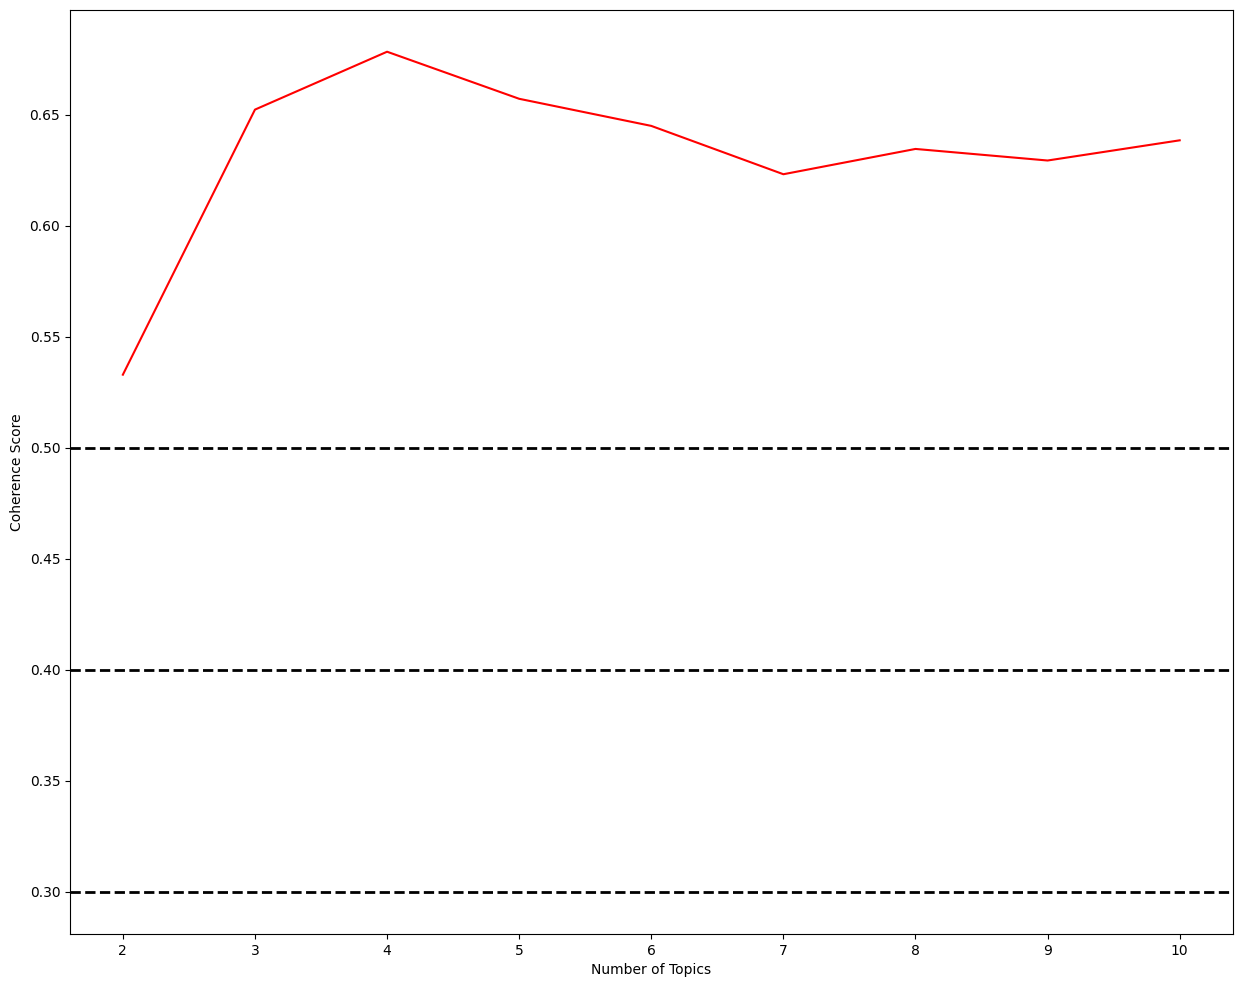

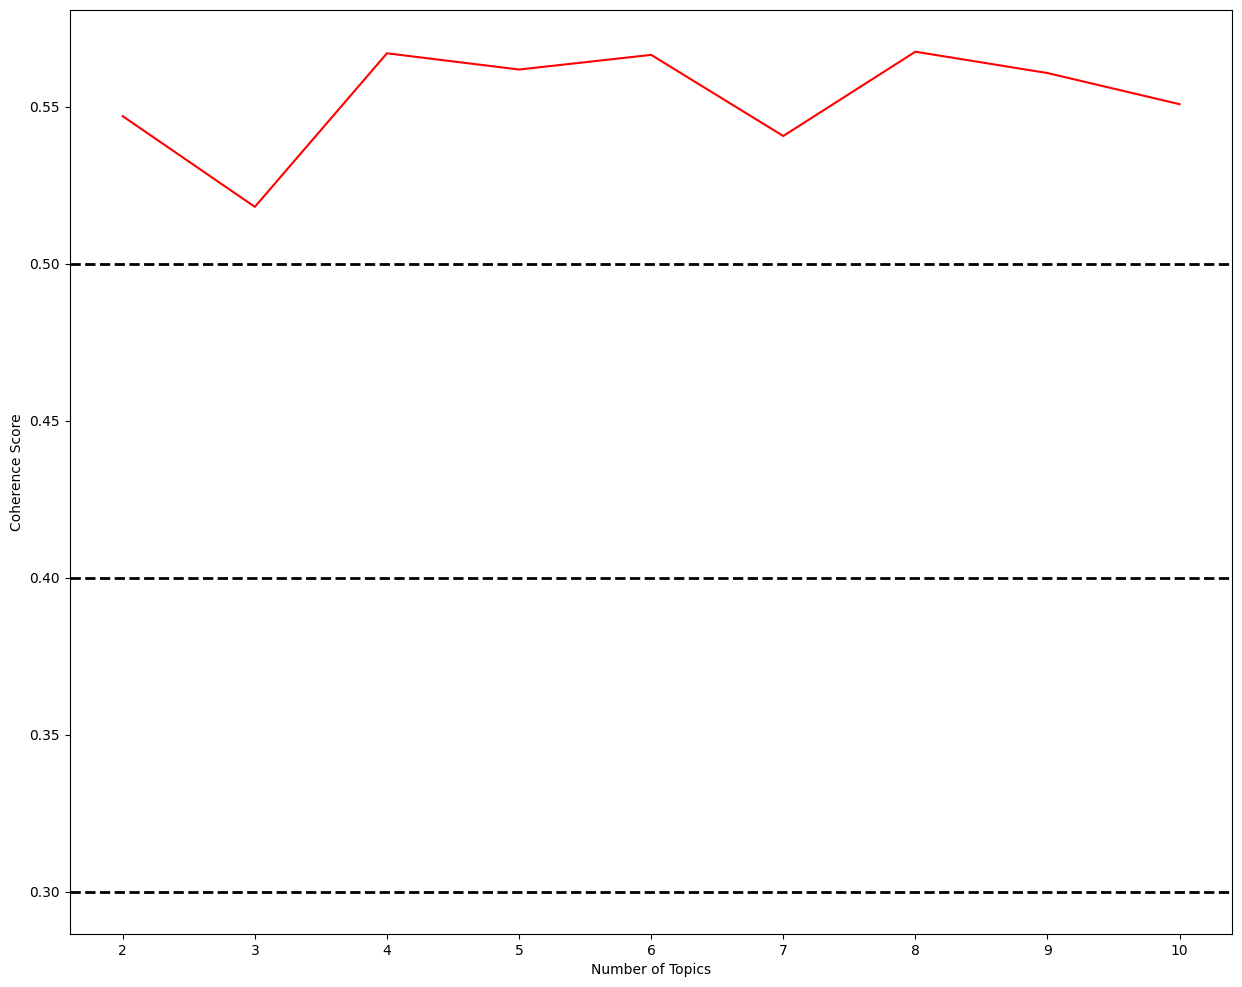


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:19<02:39, 19.90s/it]

Topic #1:
0.346*"staff" + 0.251*"check" + 0.193*"bed" + 0.165*"clean" + 0.156*"even" + 0.151*"good" + 0.150*"small" + 0.145*"book" + 0.143*"ask" + 0.131*"reception" + 0.127*"guest" + 0.127*"also" + 0.125*"could" + 0.123*"need" + 0.122*"bad" + 0.119*"door" + 0.115*"come" + 0.114*"like" + 0.113*"give" + 0.112*"say"

Topic #2:
0.555*"staff" + -0.455*"bed" + -0.236*"small" + -0.206*"bathroom" + -0.168*"shower" + 0.168*"check" + -0.157*"toilet" + -0.154*"dirty" + -0.148*"door" + -0.140*"smell" + 0.138*"guest" + -0.129*"water" + -0.123*"clean" + -0.109*"floor" + -0.106*"change" + 0.083*"tell" + 0.081*"book" + 0.080*"breakfast" + 0.075*"checkout" + 0.075*"service"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:40<02:20, 20.12s/it]

Topic #1:
0.346*"staff" + 0.251*"check" + 0.193*"bed" + 0.165*"clean" + 0.156*"even" + 0.151*"good" + 0.150*"small" + 0.145*"book" + 0.143*"ask" + 0.131*"reception" + 0.127*"guest" + 0.127*"also" + 0.125*"could" + 0.123*"need" + 0.122*"bad" + 0.119*"door" + 0.115*"come" + 0.114*"like" + 0.113*"give" + 0.112*"say"

Topic #2:
0.555*"staff" + -0.455*"bed" + -0.236*"small" + -0.206*"bathroom" + -0.168*"shower" + 0.168*"check" + -0.157*"toilet" + -0.154*"dirty" + -0.148*"door" + -0.140*"smell" + 0.138*"guest" + -0.129*"water" + -0.123*"clean" + -0.109*"floor" + -0.106*"change" + 0.083*"tell" + 0.081*"book" + 0.080*"breakfast" + 0.075*"checkout" + 0.075*"service"

Topic #3:
0.625*"check" + -0.275*"good" + 0.237*"door" + -0.225*"small" + 0.211*"pm" + -0.189*"clean" + -0.187*"staff" + -0.153*"breakfast" + -0.128*"food" + -0.110*"also" + 0.108*"wait" + -0.093*"price" + -0.093*"area" + -0.092*"well" + -0.091*"nice" + 0.089*"bed" + 0.089*"back" + 0.082*"reception" + 0.080*"say" + -0.080*"like"

-

 33%|████████████████████████████                                                        | 3/9 [01:00<02:01, 20.22s/it]

Topic #1:
0.346*"staff" + 0.251*"check" + 0.193*"bed" + 0.165*"clean" + 0.156*"even" + 0.151*"good" + 0.150*"small" + 0.145*"book" + 0.143*"ask" + 0.131*"reception" + 0.127*"guest" + 0.127*"also" + 0.125*"could" + 0.123*"need" + 0.122*"bad" + 0.119*"door" + 0.115*"come" + 0.114*"like" + 0.113*"give" + 0.112*"say"

Topic #2:
0.555*"staff" + -0.455*"bed" + -0.236*"small" + -0.206*"bathroom" + -0.168*"shower" + 0.168*"check" + -0.157*"toilet" + -0.154*"dirty" + -0.148*"door" + -0.140*"smell" + 0.138*"guest" + -0.129*"water" + -0.123*"clean" + -0.109*"floor" + -0.106*"change" + 0.083*"tell" + 0.081*"book" + 0.080*"breakfast" + 0.075*"checkout" + 0.075*"service"

Topic #3:
-0.625*"check" + 0.275*"good" + -0.237*"door" + 0.225*"small" + -0.211*"pm" + 0.189*"clean" + 0.187*"staff" + 0.153*"breakfast" + 0.128*"food" + 0.110*"also" + -0.108*"wait" + 0.093*"price" + 0.093*"area" + 0.092*"well" + 0.091*"nice" + -0.089*"bed" + -0.089*"back" + -0.082*"reception" + -0.080*"say" + 0.080*"like"

Topic

 44%|█████████████████████████████████████▎                                              | 4/9 [01:21<01:41, 20.40s/it]

Topic #1:
0.346*"staff" + 0.251*"check" + 0.193*"bed" + 0.165*"clean" + 0.156*"even" + 0.151*"good" + 0.150*"small" + 0.145*"book" + 0.143*"ask" + 0.131*"reception" + 0.127*"guest" + 0.127*"also" + 0.125*"could" + 0.123*"need" + 0.122*"bad" + 0.119*"door" + 0.115*"come" + 0.114*"like" + 0.113*"give" + 0.112*"say"

Topic #2:
0.555*"staff" + -0.455*"bed" + -0.236*"small" + -0.206*"bathroom" + -0.168*"shower" + 0.168*"check" + -0.157*"toilet" + -0.154*"dirty" + -0.148*"door" + -0.140*"smell" + 0.138*"guest" + -0.129*"water" + -0.123*"clean" + -0.109*"floor" + -0.106*"change" + 0.083*"tell" + 0.081*"book" + 0.080*"breakfast" + 0.075*"checkout" + 0.075*"service"

Topic #3:
0.625*"check" + -0.275*"good" + 0.237*"door" + -0.225*"small" + 0.211*"pm" + -0.189*"clean" + -0.187*"staff" + -0.153*"breakfast" + -0.128*"food" + -0.110*"also" + 0.108*"wait" + -0.093*"price" + -0.093*"area" + -0.092*"well" + -0.091*"nice" + 0.089*"bed" + 0.089*"back" + 0.082*"reception" + 0.080*"say" + -0.080*"like"

T

 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:42<01:22, 20.62s/it]

Topic #1:
0.346*"staff" + 0.251*"check" + 0.193*"bed" + 0.165*"clean" + 0.156*"even" + 0.151*"good" + 0.150*"small" + 0.145*"book" + 0.143*"ask" + 0.131*"reception" + 0.127*"guest" + 0.127*"also" + 0.125*"could" + 0.123*"need" + 0.122*"bad" + 0.119*"door" + 0.115*"come" + 0.114*"like" + 0.113*"give" + 0.112*"say"

Topic #2:
-0.555*"staff" + 0.455*"bed" + 0.236*"small" + 0.206*"bathroom" + 0.168*"shower" + -0.168*"check" + 0.157*"toilet" + 0.154*"dirty" + 0.148*"door" + 0.140*"smell" + -0.138*"guest" + 0.129*"water" + 0.123*"clean" + 0.109*"floor" + 0.106*"change" + -0.083*"tell" + -0.081*"book" + -0.080*"breakfast" + -0.075*"checkout" + -0.075*"service"

Topic #3:
0.625*"check" + -0.275*"good" + 0.237*"door" + -0.225*"small" + 0.211*"pm" + -0.189*"clean" + -0.187*"staff" + -0.153*"breakfast" + -0.128*"food" + -0.110*"also" + 0.108*"wait" + -0.093*"price" + -0.093*"area" + -0.092*"well" + -0.091*"nice" + 0.089*"bed" + 0.089*"back" + 0.082*"reception" + 0.080*"say" + -0.080*"like"

Topic

 67%|████████████████████████████████████████████████████████                            | 6/9 [02:03<01:02, 20.84s/it]

Topic #1:
0.346*"staff" + 0.251*"check" + 0.193*"bed" + 0.165*"clean" + 0.156*"even" + 0.151*"good" + 0.150*"small" + 0.145*"book" + 0.143*"ask" + 0.131*"reception" + 0.127*"guest" + 0.127*"also" + 0.125*"could" + 0.123*"need" + 0.122*"bad" + 0.119*"door" + 0.115*"come" + 0.114*"like" + 0.113*"give" + 0.112*"say"

Topic #2:
0.555*"staff" + -0.455*"bed" + -0.236*"small" + -0.206*"bathroom" + -0.168*"shower" + 0.168*"check" + -0.157*"toilet" + -0.154*"dirty" + -0.148*"door" + -0.140*"smell" + 0.138*"guest" + -0.129*"water" + -0.123*"clean" + -0.109*"floor" + -0.106*"change" + 0.083*"tell" + 0.081*"book" + 0.080*"breakfast" + 0.075*"checkout" + 0.075*"service"

Topic #3:
-0.625*"check" + 0.275*"good" + -0.237*"door" + 0.225*"small" + -0.211*"pm" + 0.189*"clean" + 0.187*"staff" + 0.153*"breakfast" + 0.128*"food" + 0.110*"also" + -0.108*"wait" + 0.093*"price" + 0.093*"area" + 0.092*"well" + 0.091*"nice" + -0.089*"bed" + -0.089*"back" + -0.082*"reception" + -0.080*"say" + 0.080*"like"

Topic

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [02:24<00:41, 20.97s/it]

Topic #1:
0.346*"staff" + 0.251*"check" + 0.193*"bed" + 0.165*"clean" + 0.156*"even" + 0.151*"good" + 0.150*"small" + 0.145*"book" + 0.143*"ask" + 0.131*"reception" + 0.127*"guest" + 0.127*"also" + 0.125*"could" + 0.123*"need" + 0.122*"bad" + 0.119*"door" + 0.115*"come" + 0.114*"like" + 0.113*"give" + 0.112*"say"

Topic #2:
0.555*"staff" + -0.455*"bed" + -0.236*"small" + -0.206*"bathroom" + -0.168*"shower" + 0.168*"check" + -0.157*"toilet" + -0.154*"dirty" + -0.148*"door" + -0.140*"smell" + 0.138*"guest" + -0.129*"water" + -0.123*"clean" + -0.109*"floor" + -0.106*"change" + 0.083*"tell" + 0.081*"book" + 0.080*"breakfast" + 0.075*"checkout" + 0.075*"service"

Topic #3:
-0.625*"check" + 0.275*"good" + -0.237*"door" + 0.225*"small" + -0.211*"pm" + 0.189*"clean" + 0.187*"staff" + 0.153*"breakfast" + 0.128*"food" + 0.110*"also" + -0.108*"wait" + 0.093*"price" + 0.093*"area" + 0.092*"well" + 0.091*"nice" + -0.089*"bed" + -0.089*"back" + -0.082*"reception" + -0.080*"say" + 0.080*"like"

Topic

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:46<00:21, 21.12s/it]

Topic #1:
0.346*"staff" + 0.251*"check" + 0.193*"bed" + 0.165*"clean" + 0.156*"even" + 0.151*"good" + 0.150*"small" + 0.145*"book" + 0.143*"ask" + 0.131*"reception" + 0.127*"guest" + 0.127*"also" + 0.125*"could" + 0.123*"need" + 0.122*"bad" + 0.119*"door" + 0.115*"come" + 0.114*"like" + 0.113*"give" + 0.112*"say"

Topic #2:
0.555*"staff" + -0.455*"bed" + -0.236*"small" + -0.206*"bathroom" + -0.168*"shower" + 0.168*"check" + -0.157*"toilet" + -0.154*"dirty" + -0.148*"door" + -0.140*"smell" + 0.138*"guest" + -0.129*"water" + -0.123*"clean" + -0.109*"floor" + -0.106*"change" + 0.083*"tell" + 0.081*"book" + 0.080*"breakfast" + 0.075*"checkout" + 0.075*"service"

Topic #3:
-0.625*"check" + 0.275*"good" + -0.237*"door" + 0.225*"small" + -0.211*"pm" + 0.189*"clean" + 0.187*"staff" + 0.153*"breakfast" + 0.128*"food" + 0.110*"also" + -0.108*"wait" + 0.093*"price" + 0.093*"area" + 0.092*"well" + 0.091*"nice" + -0.089*"bed" + -0.089*"back" + -0.082*"reception" + -0.080*"say" + 0.080*"like"

Topic

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:07<00:00, 20.87s/it]


Topic #1:
0.346*"staff" + 0.251*"check" + 0.193*"bed" + 0.165*"clean" + 0.156*"even" + 0.151*"good" + 0.150*"small" + 0.145*"book" + 0.143*"ask" + 0.131*"reception" + 0.127*"guest" + 0.127*"also" + 0.125*"could" + 0.123*"need" + 0.122*"bad" + 0.119*"door" + 0.115*"come" + 0.114*"like" + 0.113*"give" + 0.112*"say"

Topic #2:
0.555*"staff" + -0.455*"bed" + -0.236*"small" + -0.206*"bathroom" + -0.168*"shower" + 0.168*"check" + -0.157*"toilet" + -0.154*"dirty" + -0.148*"door" + -0.140*"smell" + 0.138*"guest" + -0.129*"water" + -0.123*"clean" + -0.109*"floor" + -0.106*"change" + 0.083*"tell" + 0.081*"book" + 0.080*"breakfast" + 0.075*"checkout" + 0.075*"service"

Topic #3:
0.625*"check" + -0.275*"good" + 0.237*"door" + -0.225*"small" + 0.211*"pm" + -0.189*"clean" + -0.187*"staff" + -0.153*"breakfast" + -0.128*"food" + -0.110*"also" + 0.108*"wait" + -0.093*"price" + -0.093*"area" + -0.092*"well" + -0.091*"nice" + 0.089*"bed" + 0.089*"back" + 0.082*"reception" + 0.080*"say" + -0.080*"like"

T

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:05<00:44,  5.51s/it]

Topic #1:
0.026*"staff" + 0.021*"good" + 0.015*"small" + 0.015*"check" + 0.015*"clean" + 0.015*"breakfast" + 0.013*"need" + 0.013*"bathroom" + 0.012*"bed" + 0.012*"could" + 0.011*"even" + 0.011*"guest" + 0.011*"price" + 0.009*"nothing" + 0.009*"water" + 0.009*"service" + 0.009*"book" + 0.009*"well" + 0.008*"also" + 0.008*"pay"

Topic #2:
0.023*"small" + 0.021*"staff" + 0.018*"like" + 0.018*"bed" + 0.016*"check" + 0.016*"clean" + 0.014*"reception" + 0.014*"bad" + 0.013*"book" + 0.012*"shower" + 0.011*"smell" + 0.011*"toilet" + 0.011*"door" + 0.011*"dirty" + 0.011*"water" + 0.010*"even" + 0.009*"ask" + 0.009*"work" + 0.009*"service" + 0.009*"well"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:10<00:35,  5.03s/it]

Topic #1:
0.034*"small" + 0.021*"nothing" + 0.019*"staff" + 0.017*"bathroom" + 0.017*"good" + 0.015*"bed" + 0.015*"water" + 0.013*"toilet" + 0.012*"pool" + 0.012*"even" + 0.011*"guest" + 0.011*"take" + 0.010*"smell" + 0.010*"come" + 0.010*"clean" + 0.009*"like" + 0.009*"price" + 0.009*"shower" + 0.009*"check" + 0.009*"never"

Topic #2:
0.025*"staff" + 0.022*"clean" + 0.019*"small" + 0.019*"check" + 0.016*"breakfast" + 0.015*"like" + 0.014*"bed" + 0.013*"book" + 0.012*"dirty" + 0.012*"need" + 0.012*"well" + 0.012*"door" + 0.011*"floor" + 0.011*"work" + 0.011*"ask" + 0.010*"bathroom" + 0.009*"service" + 0.009*"bad" + 0.009*"use" + 0.009*"give"

Topic #3:
0.026*"staff" + 0.021*"good" + 0.017*"check" + 0.016*"bad" + 0.016*"could" + 0.016*"bed" + 0.015*"also" + 0.015*"service" + 0.013*"even" + 0.013*"smell" + 0.013*"shower" + 0.012*"clean" + 0.011*"book" + 0.011*"water" + 0.011*"reception" + 0.009*"give" + 0.009*"guest" + 0.009*"quite" + 0.009*"request" + 0.009*"recommend"

----------------

 33%|████████████████████████████                                                        | 3/9 [00:14<00:29,  4.87s/it]

Topic #1:
0.029*"staff" + 0.026*"need" + 0.020*"well" + 0.017*"breakfast" + 0.015*"check" + 0.012*"water" + 0.012*"guest" + 0.012*"clean" + 0.011*"bit" + 0.011*"ask" + 0.011*"could" + 0.011*"bed" + 0.010*"sleep" + 0.010*"service" + 0.010*"book" + 0.009*"find" + 0.009*"pm" + 0.009*"work" + 0.009*"reception" + 0.008*"like"

Topic #2:
0.032*"staff" + 0.019*"bed" + 0.018*"bathroom" + 0.018*"good" + 0.017*"book" + 0.017*"small" + 0.014*"even" + 0.013*"shower" + 0.011*"also" + 0.011*"toilet" + 0.011*"door" + 0.010*"bad" + 0.010*"guest" + 0.010*"check" + 0.010*"clean" + 0.009*"quite" + 0.009*"water" + 0.009*"make" + 0.009*"around" + 0.009*"open"

Topic #3:
0.027*"check" + 0.024*"clean" + 0.023*"staff" + 0.022*"small" + 0.021*"nothing" + 0.018*"bed" + 0.014*"breakfast" + 0.013*"good" + 0.013*"service" + 0.012*"door" + 0.011*"reception" + 0.011*"like" + 0.011*"could" + 0.011*"bad" + 0.010*"give" + 0.010*"take" + 0.010*"book" + 0.009*"bathroom" + 0.009*"come" + 0.009*"recommend"

Topic #4:
0.024

 44%|█████████████████████████████████████▎                                              | 4/9 [00:19<00:24,  4.88s/it]

Topic #1:
0.019*"shower" + 0.019*"small" + 0.019*"bed" + 0.018*"book" + 0.016*"water" + 0.015*"well" + 0.014*"floor" + 0.014*"even" + 0.013*"open" + 0.013*"really" + 0.013*"could" + 0.012*"door" + 0.011*"find" + 0.010*"also" + 0.010*"good" + 0.010*"around" + 0.009*"use" + 0.009*"staff" + 0.009*"bit" + 0.009*"sleep"

Topic #2:
0.032*"clean" + 0.023*"service" + 0.020*"need" + 0.017*"dirty" + 0.017*"small" + 0.016*"feel" + 0.015*"water" + 0.014*"check" + 0.014*"good" + 0.014*"shower" + 0.013*"money" + 0.013*"like" + 0.012*"staff" + 0.012*"bathroom" + 0.012*"bed" + 0.011*"old" + 0.011*"come" + 0.011*"smell" + 0.010*"star" + 0.009*"guest"

Topic #3:
0.038*"good" + 0.027*"small" + 0.026*"staff" + 0.024*"breakfast" + 0.021*"book" + 0.019*"bad" + 0.017*"toilet" + 0.017*"clean" + 0.013*"could" + 0.013*"work" + 0.012*"also" + 0.011*"ask" + 0.011*"like" + 0.009*"sleep" + 0.009*"floor" + 0.009*"recommend" + 0.009*"shower" + 0.009*"smell" + 0.009*"bathroom" + 0.009*"singapore"

Topic #4:
0.039*"sta

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:23<00:18,  4.63s/it]

Topic #1:
0.032*"staff" + 0.026*"good" + 0.023*"check" + 0.022*"small" + 0.020*"book" + 0.017*"even" + 0.017*"bed" + 0.016*"like" + 0.015*"reception" + 0.015*"clean" + 0.014*"facility" + 0.013*"guest" + 0.013*"give" + 0.012*"bathroom" + 0.012*"service" + 0.011*"need" + 0.011*"experience" + 0.010*"bad" + 0.010*"never" + 0.010*"say"

Topic #2:
0.030*"small" + 0.020*"bit" + 0.019*"staff" + 0.017*"could" + 0.014*"door" + 0.014*"quite" + 0.014*"like" + 0.014*"bad" + 0.014*"good" + 0.013*"floor" + 0.013*"clean" + 0.013*"look" + 0.012*"check" + 0.012*"also" + 0.012*"smell" + 0.011*"dirty" + 0.011*"bed" + 0.011*"shower" + 0.010*"however" + 0.010*"open"

Topic #3:
0.037*"clean" + 0.028*"staff" + 0.026*"book" + 0.025*"bed" + 0.017*"ask" + 0.015*"change" + 0.013*"service" + 0.013*"good" + 0.013*"dirty" + 0.012*"give" + 0.012*"smell" + 0.012*"work" + 0.011*"small" + 0.011*"around" + 0.011*"well" + 0.011*"find" + 0.011*"want" + 0.010*"people" + 0.010*"pay" + 0.009*"come"

Topic #4:
0.033*"check" + 

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:27<00:13,  4.41s/it]

Topic #1:
0.024*"shower" + 0.021*"clean" + 0.020*"water" + 0.019*"dirty" + 0.018*"work" + 0.018*"want" + 0.017*"floor" + 0.016*"check" + 0.015*"door" + 0.014*"small" + 0.014*"staff" + 0.013*"bad" + 0.012*"breakfast" + 0.012*"well" + 0.012*"bathroom" + 0.012*"need" + 0.011*"smell" + 0.011*"could" + 0.011*"ac" + 0.011*"good"

Topic #2:
0.027*"clean" + 0.024*"breakfast" + 0.023*"could" + 0.022*"check" + 0.018*"bed" + 0.017*"small" + 0.015*"well" + 0.015*"need" + 0.014*"good" + 0.013*"water" + 0.013*"staff" + 0.013*"bathroom" + 0.012*"look" + 0.012*"old" + 0.011*"dirty" + 0.011*"facility" + 0.011*"service" + 0.010*"ask" + 0.010*"singapore" + 0.009*"bit"

Topic #3:
0.030*"staff" + 0.027*"small" + 0.022*"bed" + 0.018*"check" + 0.016*"like" + 0.015*"breakfast" + 0.014*"around" + 0.013*"reception" + 0.013*"good" + 0.013*"clean" + 0.012*"come" + 0.012*"even" + 0.012*"area" + 0.012*"give" + 0.011*"service" + 0.011*"could" + 0.010*"bad" + 0.010*"back" + 0.010*"next" + 0.009*"need"

Topic #4:
0.03

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:31<00:08,  4.27s/it]

Topic #1:
0.040*"bathroom" + 0.030*"small" + 0.023*"toilet" + 0.019*"clean" + 0.016*"good" + 0.015*"window" + 0.015*"shower" + 0.015*"quite" + 0.014*"well" + 0.013*"bed" + 0.013*"price" + 0.013*"tiny" + 0.012*"bit" + 0.012*"give" + 0.011*"check" + 0.011*"could" + 0.011*"come" + 0.011*"light" + 0.010*"make" + 0.010*"bad"

Topic #2:
0.035*"staff" + 0.024*"check" + 0.020*"book" + 0.019*"bed" + 0.019*"good" + 0.019*"service" + 0.014*"food" + 0.014*"small" + 0.012*"need" + 0.011*"water" + 0.011*"meet" + 0.011*"could" + 0.010*"take" + 0.010*"breakfast" + 0.010*"long" + 0.010*"well" + 0.010*"like" + 0.010*"guest" + 0.009*"hour" + 0.009*"people"

Topic #3:
0.045*"staff" + 0.025*"bed" + 0.023*"breakfast" + 0.015*"bad" + 0.014*"check" + 0.014*"ask" + 0.013*"old" + 0.012*"could" + 0.011*"guest" + 0.011*"well" + 0.011*"change" + 0.011*"give" + 0.010*"service" + 0.010*"bit" + 0.010*"much" + 0.010*"area" + 0.010*"smell" + 0.010*"reception" + 0.009*"like" + 0.009*"even"

Topic #4:
0.025*"water" + 0.0

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:35<00:04,  4.18s/it]

Topic #1:
0.030*"small" + 0.028*"staff" + 0.025*"good" + 0.023*"breakfast" + 0.018*"water" + 0.018*"service" + 0.016*"need" + 0.015*"clean" + 0.012*"old" + 0.012*"bed" + 0.012*"check" + 0.011*"reception" + 0.011*"well" + 0.011*"singapore" + 0.011*"give" + 0.010*"bad" + 0.009*"book" + 0.009*"outside" + 0.009*"first" + 0.009*"sleep"

Topic #2:
0.026*"bathroom" + 0.022*"water" + 0.022*"door" + 0.021*"bed" + 0.020*"clean" + 0.019*"book" + 0.018*"staff" + 0.016*"breakfast" + 0.016*"check" + 0.015*"ask" + 0.014*"could" + 0.013*"small" + 0.013*"price" + 0.012*"bad" + 0.012*"toilet" + 0.012*"shower" + 0.011*"old" + 0.011*"open" + 0.011*"money" + 0.010*"like"

Topic #3:
0.032*"staff" + 0.020*"good" + 0.020*"bed" + 0.019*"smell" + 0.017*"reception" + 0.017*"like" + 0.014*"even" + 0.014*"area" + 0.014*"book" + 0.013*"ask" + 0.013*"small" + 0.013*"dirty" + 0.012*"could" + 0.012*"give" + 0.011*"around" + 0.011*"also" + 0.011*"floor" + 0.010*"really" + 0.010*"toilet" + 0.009*"door"

Topic #4:
0.024*

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.48s/it]

Topic #1:
0.029*"staff" + 0.027*"bed" + 0.024*"check" + 0.019*"small" + 0.014*"good" + 0.014*"clean" + 0.013*"give" + 0.013*"bad" + 0.012*"even" + 0.011*"shower" + 0.010*"facility" + 0.010*"bathroom" + 0.010*"singapore" + 0.009*"could" + 0.009*"pm" + 0.009*"guest" + 0.009*"smell" + 0.009*"recommend" + 0.009*"service" + 0.009*"change"

Topic #2:
0.029*"bed" + 0.021*"bathroom" + 0.019*"smell" + 0.019*"staff" + 0.016*"price" + 0.016*"also" + 0.015*"like" + 0.014*"door" + 0.014*"clean" + 0.013*"even" + 0.013*"around" + 0.012*"area" + 0.012*"water" + 0.012*"friendly" + 0.011*"good" + 0.010*"pool" + 0.010*"cleanliness" + 0.010*"small" + 0.009*"floor" + 0.009*"nothing"

Topic #3:
0.028*"guest" + 0.025*"need" + 0.024*"staff" + 0.023*"check" + 0.020*"like" + 0.017*"request" + 0.017*"facility" + 0.015*"also" + 0.014*"service" + 0.014*"small" + 0.013*"available" + 0.012*"pool" + 0.012*"bit" + 0.010*"make" + 0.010*"want" + 0.010*"work" + 0.009*"lobby" + 0.009*"toilet" + 0.009*"high" + 0.009*"early

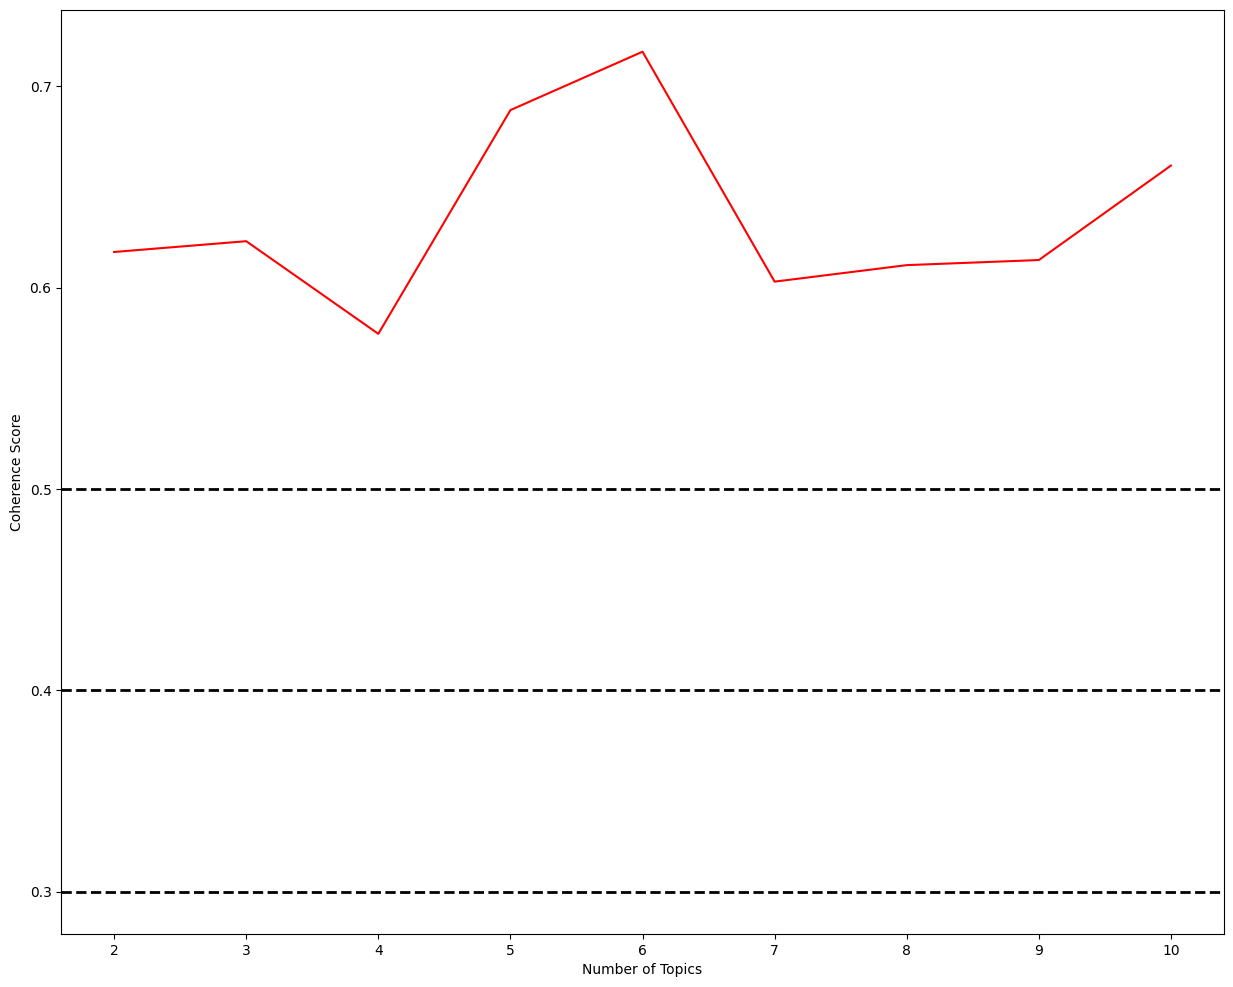

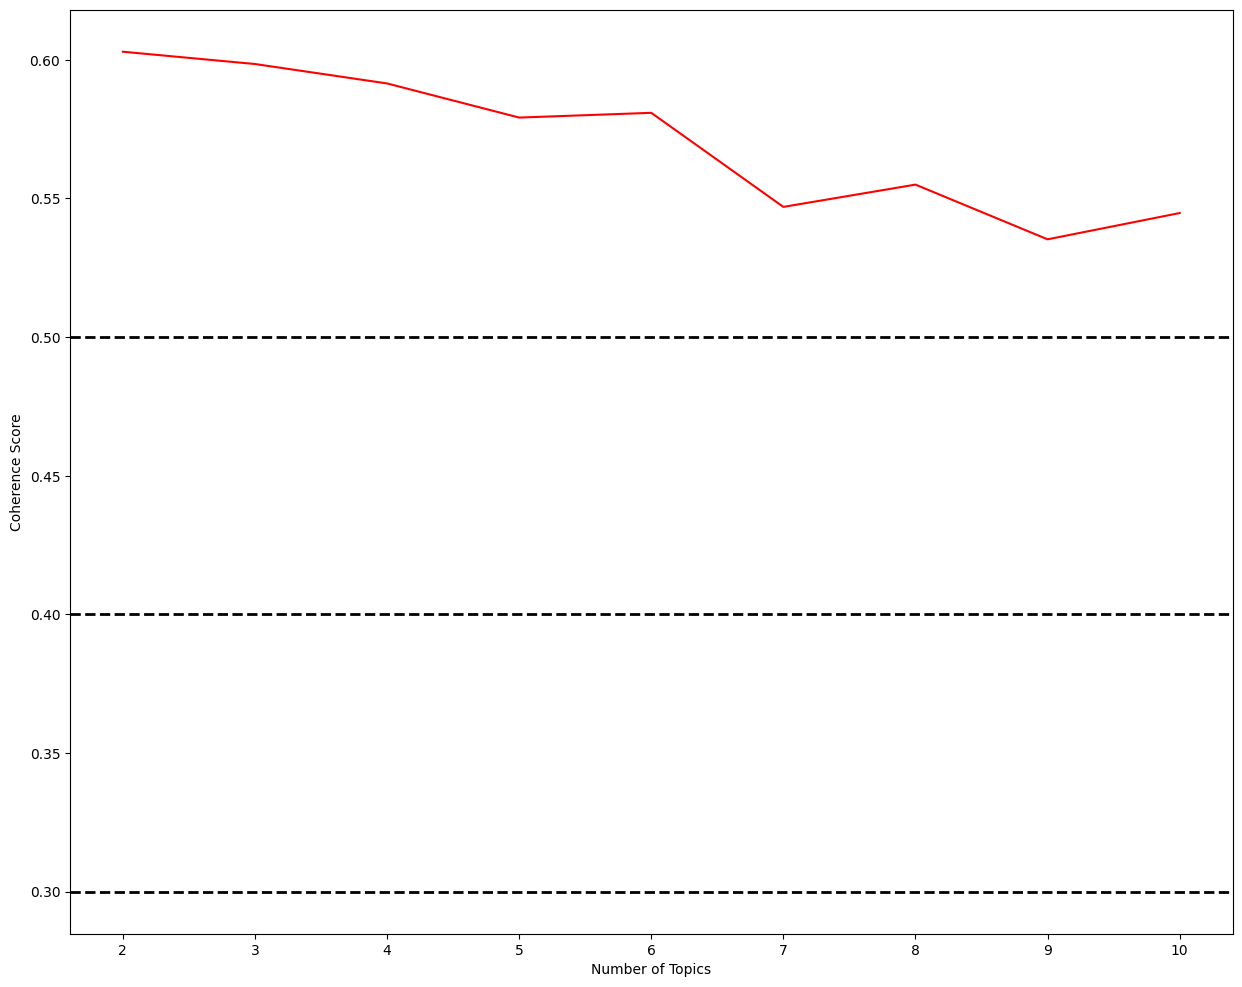

In [10]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v2"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [11]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.532835,df_pos
1,LSI,3,0.652209,df_pos
2,LSI,4,0.678276,df_pos
3,LSI,5,0.657079,df_pos
4,LSI,6,0.644873,df_pos
5,LSI,7,0.623103,df_pos
6,LSI,8,0.634497,df_pos
7,LSI,9,0.629285,df_pos
8,LSI,10,0.638377,df_pos
0,LDA,2,0.546974,df_pos


In [12]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,6,0.717162,df_neg
1,LSI,4,0.678276,df_pos


In [13]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 6

Topic 1: staff, check, bed, clean, even, good, small, book, ask, reception

Topic 2: staff, bed, small, bathroom, shower, check, toilet, dirty, door, smell

Topic 3: check, good, door, small, pm, clean, staff, breakfast, food, also

Topic 4: bed, small, shower, check, change, water, toilet, ask, dirty, bathroom

Topic 5: staff, bed, door, water, even, pm, change, ask, small, need

Topic 6: breakfast, small, clean, staff, shower, water, good, book, toilet, check

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 4

Topic 1: good, staff, clean, great, nice, small, bed, friendly, also, check

Topic 2: good, staff, great, friendly, check, clean, helpful, nice, book, food

Topic 3: staff, good, friendly, bed, helpful, small, also, clean, book, toilet

Topic 4: clean, check, book, nice, pm, call, service, near, guest, reception

----------



In [14]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-26 23:03:20.436597
Text processing spent 0:21:40.278796
